# E-Commerce Bookstore Sales Analysis 

In [43]:
import sqlite3, pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("Book_Nook_New.db")

with open("Book_Nook_New.db.sql", "r") as f:
    conn.executescript(f.read())

# Test that the new database now works
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,Books
1,Customers
2,Purchases


During my initial setup where I wanted to connect to the database, I recieved an error: `DatabaseError: file is not a database`. 

It took me a while to figure out what the issue was because my database was in the correct folder, the file was not corrupted or had specific persmission on it. After troubleshooting, I realized that the file's format was not an actual SQLite file (this is what it was: `ASCII text`) even though it opened in DB Browser for SQLite. 

I had to re-save the file which was initially called `Book_Nook_Updated.db` and create a new database called `Book_Nook_New.db`, import it again, and make sure that it was able to connect in Jupyter Notebooks.

Finally, I was able to connect to my database, and the list of the tables confirms that: `Books`, `Customers`, and `Purchases`. Now that it is connected, I can begin exploring and querying the data directly here in Jupyter. 

## Analyzing the Data Structure

In [23]:
pd.read_sql_query("""
    
SELECT * 
FROM Books 
LIMIT 5;
    
""", conn)

,Book_ID,Title,Author,Genre,Published_Year,Page_Count,Format,Price
0,1,"First-Time Caller (Heartstrings, #1)",B.K. Borison,Romance,2025,448,Paperback,8.87
1,2,"The Coven (Coven of Bones, #1)",Harper L. Woods,Paranormal Romance,2023,298,eBook,7.33
2,3,"My Funny Demon Valentine (Hell Bent, #1)",Aurora Ascher,Paranormal Romance,2021,360,eBook,8.73
3,4,The Carver (Fifth Republic #2),Penelope Sky,Dark Romance,2025,318,eBook,20.07
4,5,"The Butcher (Fifth Republic, #1)",Penelope Sky,Dark Romance,2025,302,eBook,9.53


I am treating this like real-world data and as if I have not seen this data before. The first thing to do is to understand and analyze the structure of the data for each table. 

This will help me understand the relationships between the tables, confirm column names, the data types that are in each column, and confirm that the data loaded correctly after having to re-save and importing the database.

The `Books` table contains details about each book in the inventory, including:
- `book_id` which is the unique identifier, `title`, `author`, `genre`, `format`, `price` and `publication_year`

The first five rows of data confirms that the data loaded successfully and the fields match the expected schema.

In [70]:
pd.read_sql_query("""
   
SELECT * 
FROM Customers 
LIMIT 5;
   
""", conn)

,Customer_ID,First_Name,Last_Name,Email,Phone_Number,Age,Gender,State
0,1,Kathleen,Adams,kathleenadams44@gmail.com,472-752-4972,48,Female,VT
1,2,Marcia,Sanchez,marciasanchez20@gmail.com,651-424-4676,53,Female,UT
2,3,John,Waller,johnwaller29@gmail.com,455-945-2613,38,Male,MN
3,4,Bradley,Stewart,bradleystewart34@gmail.com,170-985-6389,75,Male,RI
4,5,Megan,Miller,meganmiller91@gmail.com,191-165-6476,59,Female,VT


The Customers table includes: `Customer_ID`, `first_name`, `last_name`, `email`, `phone_number`, `age`, `gender`, and `state`. 

This table will be used to analyze purchase trends by customer or state.

In [68]:
pd.read_sql_query("""
   
SELECT * 
FROM Purchases
LIMIT 5;
    
""", conn)

,Purchase_ID,Customer_ID,Book_ID,Quantity,Purchased_Date,Total_Amount
0,1,23,1,3,2025-01-26,26.61
1,2,24,64,1,2025-02-25,25.63
2,3,33,103,3,2025-05-13,66.57
3,4,44,110,2,2025-06-22,45.28
4,5,34,88,2,2025-01-03,18.88


The Purchases table connects the Books and Customers table through the columns: `purchase_id`, `customers_id`, and `book_id`.

## Cleaning the Data

Before analyzing the data, I will perform a series of validations to make sure the database is clean and consistent.

This version of my database is clean and does not include any discrepancies, I created a separate SQL file that contains intentional discrepancies that could be run independently to introduce data issues such as: 
- duplicate book titles
- null genre 
- null location for customers 
- null emails for customers
- duplicate customers

**Checking for Discrepancies**

If I am treating this as real-world data, I would write queries to check and make sure everything is clean and accurate. The following queries are examples of a few validation checks used to detect issues such as null and duplicate data:

**Checking if there are null values:**

    SELECT * 
    FROM Books 
    WHERE Author IS NULL;

If I don't want to write separate queries to see if each column in the table is NULL, I can write the query like this: 

    SELECT * 
    FROM Books 
    WHERE Author IS NULL
    OR Title IS NULL
    OR Genre IS NULL
    OR Format IS NULL
    OR Price IS NULL;


**Checking if there are duplicate titles** 

    SELECT Title COUNT(*) AS duplicate_title
    FROM Books
    GROUP BY title 
    HAVING duplicate_title > 1;


**Checking if the prices are in correct format (no negative pricing or 0)**

    SELECT * 
    FROM Books
    WHERE price is <= 0;

These are just some instances I would check for to make sure there are no discrepanicies. But others I would also check for would be whether the email formatting for customers are consistent, the format of the books are consistent in spelling, the book publication year date is within the correct range and formatted properly, and making sure every book purchased is connected to a valid customer and book.

After confirming that the database is free from missing values, duplicates, and invalid entries, the next step is to explore what the data can tell us.  

The following section uses SQL queries to analyze sales trends, customer behavior, and revenue performance across genres and formats.

## Analyzing the Data

To understand the data that I am looking at, I need to be aware of the key business questions the bookstore is
trying to address. 

Here is the problem the bookstore is trying to address: 
    
A local online bookstore noticed stagnant sales growth and declining engagement among repeat customers. They wanted 
to understand which genres and authors drive the most purchases, how different book formats 
perform (paperback, eBook, hardcover), and how customer preferences shift over time.

The analysis is centered around the following objectives: 
- Identify the genres and authors driving the most sales and revenue.  
- Compare performance across book formats.  
- Examine customer purchasing trends and engagement over time.  
- Highlight insights that can guide decisions on pricing, marketing, and inventory.

## Question #1: Which genres generate the highest revenue and purchase volume?
    

In [174]:
df_genre_sales = pd.read_sql_query("""

SELECT b.genre,
       COUNT(p.purchase_id) AS Total_Purchases,
       ROUND(SUM(b.price), 2) AS Total_Revenue,
       ROUND(AVG(b.price), 2) AS Avg_Price
FROM Books b
JOIN Purchases p ON b.book_id = p.book_id
GROUP BY b.genre
ORDER BY total_revenue DESC;

""", conn)

df_genre_sales

,Genre,Total_Purchases,Total_Revenue,Avg_Price
0,Romance,560,11363.68,20.29
1,Romantasy,48,1348.32,28.09
2,Dark Romance,80,1315.84,16.45
3,Paranormal Romance,80,694.08,8.68
4,Contemporary Fiction,16,355.04,22.19
5,Literary Fiction,16,151.04,9.44


This query joins the Purchase and Books table to analyze the total purchases and revenue by genre. 


This helps identify which genres drive the store’s profits and where marketing efforts might need to be focused.

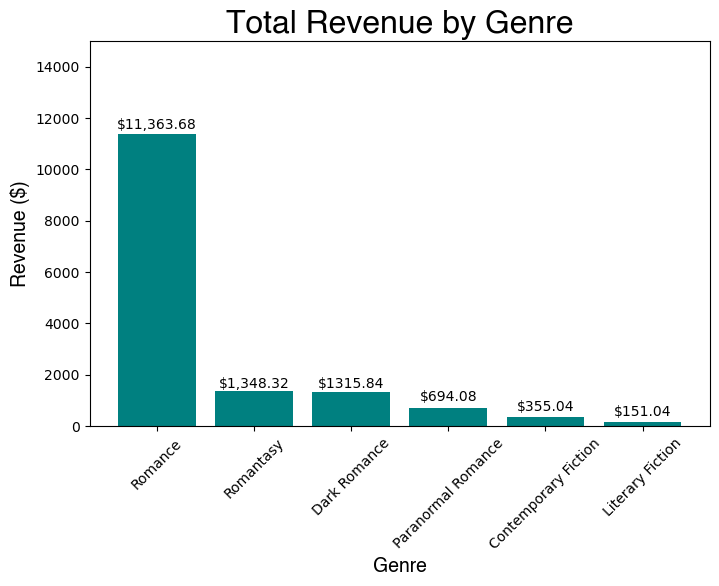

In [150]:
font1 = {'family': 'Helvetica', 'size': 23}
font2 = {'family': 'Helvetica', 'size': 14}
plt.figure(figsize=(8,5))
plt.bar(df_genre_sales["Genre"], df_genre_sales["total_revenue"], color = 'teal')
plt.title("Total Revenue by Genre", fontdict = font1)
plt.xlabel("Genre", fontdict = font2)
plt.ylabel("Revenue ($)", fontdict = font2)
plt.xticks(rotation=45)
plt.ylim(0, 15000)

#adding value labels above each bar
plt.text(0, 11600, '$11,363.68', ha = 'center')
plt.text(1, 1500, '$1,348.32', ha = 'center')
plt.text(2, 1500, '$1315.84', ha = 'center')
plt.text(3, 1000, '$694.08', ha = 'center')
plt.text(4, 600, '$355.04', ha = 'center')
plt.text(5, 400, '$151.04', ha = 'center')

plt.show()

Takeway: Romance and its sub genre Dark Romance and Paranormal Romance dominate both total purchase count and total 
revenue which indicates a strong customer preference and a repeat interest in these genres.  

Niche categories such as Contemporary and Literary Fiction underperform which suggest the potential for either 
targeted marketing or promotional bundles.

## Question #2: How do sales and pricing differ between Paperback, eBook, and Hardcover formats?

In [175]:
df_format = pd.read_sql_query("""

SELECT format,
       COUNT(p.purchase_id) AS Total_Purchases,
       ROUND(SUM(b.price), 2) AS Total_Revenue,
       ROUND(AVG(b.price), 2) AS Avg_Price
FROM Books b
JOIN Purchases p ON b.book_id = p.book_id
GROUP BY format
ORDER BY total_revenue DESC;

""", conn)

df_format

,Format,Total_Purchases,Total_Revenue,Avg_Price
0,Paperback,432,8570.24,19.84
1,eBook,288,4480.00,15.56
2,Hardcover,80,2177.76,27.22


This query compares total purchases, the average price of books, and total revenue by book format.  

It helps determine which format performs best in terms of both sales volume and revenue contribution.

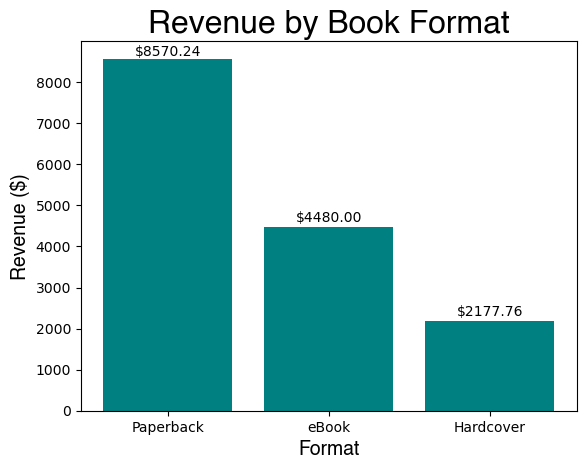

In [145]:
font1 = {'family': 'Helvetica', 'size': 23}
font2 = {'family': 'Helvetica', 'size': 14}
plt.bar(df_format["Format"], df_format["total_revenue"], color='teal')
plt.title("Revenue by Book Format", fontdict = font1)
plt.xlabel("Format", fontdict = font2)
plt.ylabel("Revenue ($)", fontdict = font2)

#adding value labels above each bar
plt.text(0, 8650, '$8570.24', ha = 'center')
plt.text(1, 4600, '$4480.00', ha = 'center')
plt.text(2, 2300 ,'$2177.76', ha = 'center')
plt.show()

Takeaway: Paperbacks lead in revenue and sales volume, accounting for nearly half of all purchases. 

Ebooks perform well in volume but contribute less revenue due to lower pricing which suggests a high demand for this format but the price margin may be low.

Hardcovers are the least purchased book format even though it has the highest average price. 

The store may want to maintain strong eBook promotions to keep engagement high to gain more purchases in this format while developing targeted campaigns for Hardcover buyers. They can offer limited-edition Hardcover bundles so customers will be inclined to purchase books in this format before the offer ends or the books sell out.

## Question # 3: Which authors contribute most to overall revenue and sales?

In [176]:
df_author_sales = pd.read_sql_query("""

SELECT b.author,
       COUNT(p.purchase_id) AS Total_Purchases,
       ROUND(SUM(b.price), 2) AS Total_Revenue
FROM Books b
JOIN Purchases p ON b.book_id = p.book_id
GROUP BY b.author
ORDER BY total_revenue DESC
LIMIT 10;

""", conn)

df_author_sales

,Author,Total_Purchases,Total_Revenue
0,Ana Huang,64,1418.08
1,Helen Hoang,64,1349.12
2,M. James,48,1250.40
3,Alexis Hall,48,1230.24
4,Carissa Broadbent,32,912.00
5,Ivy Fairbanks,32,897.60
6,S.J. Tilly,32,793.12
7,Alexa Martin,32,682.88
8,Elizabeth Acevedo,16,474.40
9,Emily Henry,32,471.36


This analysis identifies the top-performing authors by total revenue and total purchase. This gives insight to what
authors customers gravitate to and what genre they read most.

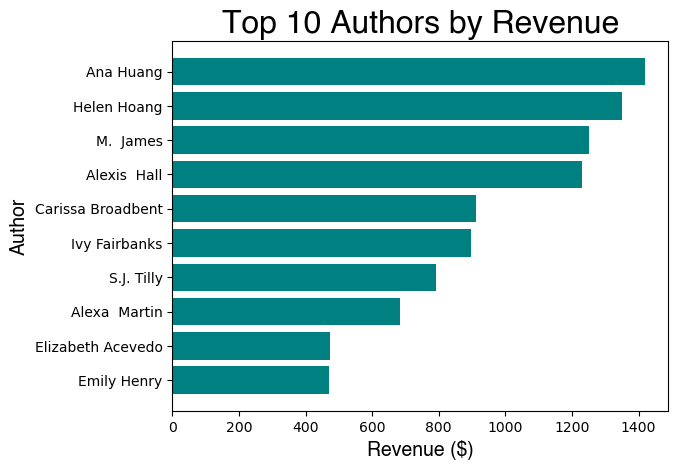

In [102]:
font1 = {'family': 'Helvetica', 'size': 23}
font2 = {'family': 'Helvetica', 'size': 14}
plt.barh(df_author_sales["Author"], df_author_sales["total_revenue"], color='teal')
plt.title("Top 10 Authors by Revenue", fontdict = font1)
plt.xlabel("Revenue ($)", fontdict = font2)
plt.ylabel("Author", fontdict = font2)
plt.gca().invert_yaxis()

#adding value labels above each bar
plt.text(0, 8650, '$8570.24', ha = 'center')
plt.text(1, 4600, '$4480.00', ha = 'center')
plt.text(2, 2300 ,'$2177.76', ha = 'center')
plt.show()

Takeaway: The top-performing authors account for a large portion of the revenue, which highlights room for creating
collections and exclusive promotions that features bestselling authors.

## Question #4: How do sales and revenue fluctuate over time?

In [177]:
df_monthly_sales = pd.read_sql_query("""

SELECT strftime('%Y-%m', p.purchased_date) AS Month,
    COUNT(p.purchase_id) AS Total_Sales,
    ROUND(SUM(b.price), 2) AS Total_Revenue
FROM Purchases p
JOIN Books b ON p.book_id = b.book_id
GROUP BY month
ORDER BY month;

""", conn)

df_monthly_sales

,Month,Total_Sales,Total_Revenue
0,2025-01,176,3574.40
1,2025-02,160,3234.24
2,2025-03,112,1789.60
3,2025-04,144,2260.00
4,2025-05,112,2180.16
5,2025-06,96,2189.60


This analysis shows the total sales and total revenue for the bookstore for each month and whether the bookstore 
experienced growth or decline in sales.

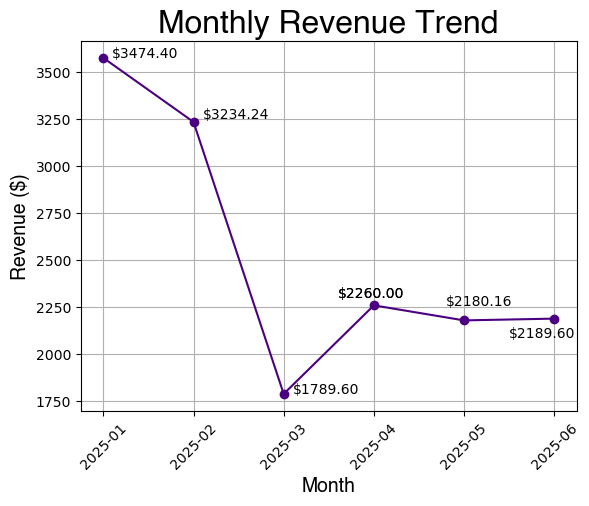

In [199]:
font1 = {'family': 'Helvetica', 'size': 23}
font2 = {'family': 'Helvetica', 'size': 14}
plt.plot(df_monthly_sales["Month"], df_monthly_sales["Total_Revenue"], marker ='o', color='indigo')
plt.title("Monthly Revenue Trend", fontdict = font1)
plt.xlabel("Month", fontdict = font2)
plt.ylabel("Revenue ($)", fontdict = font2)
plt.xticks(rotation=45)
plt.grid(True)

#add value labels for each point
plt.text(0.1, 3574, '$3474.40', ha = 'left')
plt.text(1.1, 3250, '$3234.24', ha = 'left')
plt.text(2.1, 1789, '$1789.60', ha = 'left')
plt.text(2.6, 2300, '$2260.00', ha = 'left')
plt.text(2.6, 2300, '$2260.00', ha = 'left')
plt.text(3.8, 2260, '$2180.16', ha = 'left')
plt.text(4.5, 2090, '$2189.60', ha = 'left')

plt.show()

Takeaway: Sales peaks at the beginning of the year in January but what follows is a steady decline in the middle of the year. 

Revenue follows the same pattern which suggest that both demand and spending decreases over time.

The bookstore may be experiencing post-holiday spending, with lower engagement as the year progresses.  

June maintained a slightly higher revenue per sale despite fewer total purchases, possibly due to higher-priced titles or more hardcover purchases.

## Summary of Analysis from January to June 2025

### Genre Performance

- Romance overwhelmingly leads all genres with 560 purchases and over $11,000 in revenue, showing consistent reader demand and strong profitability.  

- Subgenres like Romantasy and Dark Romance perform well in average price and revenue per book, suggesting opportunities for higher-margin titles.

- Romantasy, while having fewer total purchases (48), performs better in revenue compared to Paranormal Romance which is likely driven by its higher average price point. This suggests that while Romantasy appeals to a smaller group of readers, it attracts higher-value purchases.

- To improve performance in lower-priced categories like Paranormal Romance, the bookstore could consider promoting these titles more aggressively to increase sales volume or experiment with slight price adjustments if demand remains steady.

- Other genres such as Contemporary and Literary Fiction show lower engagement and could benefit from more targeted marketing or bundled offerings.


### Book Format Performance

- Paperbacks dominate in both purchases (432) and total revenue ($8,570.24).

- Ebooks, while priced lower on average ($15.56), show steady sales and could be used to maintain customer engagement.  

- Hardcovers are premium purchases which is the fewest in volume (80) but the highest average price ($27.22), showing potential for limited-edition or collector marketing.

### Top Performing Authors

- The top authors: Ana Huang, Helen Hoang, and M. James together generated over $4,000 in revenue, accounting for a significant share of sales.  

- Romance-focused authors dominate the list, reinforcing the genre’s strong customer loyalty and demand.

- Emerging authors like Carissa Broadbent and S.J. Tilly demonstrate mid-level engagement that could be expanded with promotional spotlights.

### Monthly Sales Trends
- Revenue peaked in January ($3,574.40) and declined steadily through March, then stabilized between April and June.  

- Total revenue for the six-month period: ~$15,000, with 770 total purchases.  

- The drop-off after Q1 suggests post-holiday seasonality or reduced promotional activity.  

- Despite fewer sales in June, average revenue per purchase remained stable, indicating consistent pricing and reader interest.